In [305]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_bvp

The fundamental equation governing our climate model is
$$c_p \frac{\partial T}{\partial t}(\varphi) = S(\varphi)\left[1 - \alpha(\varphi)\right] - \left(1 - \frac{\epsilon}{2}\right)\sigma T^4(\varphi) + D(\varphi)\frac{\partial^2 T}{\partial\varphi^2}(\varphi)$$
where $T$ is the surface temperature. Since the heat capacity $c_p$ will be multiplied by the time step $\mathrm{d}t$, which is a free parameter, we neglect $c_p$ in what follows.

## Parameters and Constants ##

In [306]:
n_lats = 100
beta = 22 * (np.pi / 180)
dt = 1e-3
eps = 0.76
S_0 = 1362
D_0 = 1e-1
sigma = 5.67e-8

Next, we create the latitude array and note the latitude step size.

In [307]:
phi = np.linspace(-np.pi / 2, np.pi / 2, n_lats)
dphi = phi[1] - phi[0]

We also create an array of latitudes in degrees, as a plotting convenience.

In [308]:
lat = phi * (180 / np.pi)

Finally, we let the diffusivity scale proportional to the circumference of the Earth.

In [309]:
D = D_0 * np.cos(phi)

## Insolation and Albedo ##
Here is one heuristic for insolation as a function of $\varphi$.

In [310]:
S = 230 * np.exp(-2 * ((lat / 60) ** 2)) + 170

Here we'll try to come up with a calculation of insolation as a function of $\varphi$ and $\beta$.

In [311]:
summer = np.maximum((S_0 / 4) * np.cos(phi - beta), 0)
winter = np.maximum((S_0 / 4) * np.cos(phi + beta), 0)
S = 0.5 * (summer + winter)

Let's plot the insolation and verify that we're getting something reasonable.

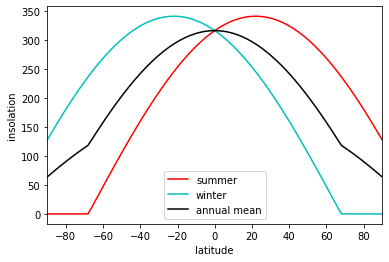

In [312]:
%matplotlib inline
_, ax = plt.subplots()

ax.plot(lat, summer, color='r', label='summer')
ax.plot(lat, winter, color='c', label='winter')
ax.plot(lat, S, color='k', label='annual mean')

ax.set_xlabel('latitude')
ax.set_ylabel('insolation')
ax.set_xlim(-90, 90)

ax.legend()

Next, we define an albedo function. For simplicity, we set
$$\alpha(\varphi) = \begin{cases}
0.3 & T(\varphi) > 273\textrm{ K} \\
0.6 & T(\varphi) \leq 273 \textrm{ K}
\end{cases}$$
In other words, when the temperature falls below freezing, the albedo jumps from $0.3$ to $0.6$.

In [313]:
def albedo(T):
    alpha = np.zeros(T.shape)
    alpha[T > 273] = 0.3
    alpha[T <= 273] = 0.6
    
    return alpha

## Estimating Derivatives in $\varphi$ ##

The last thing we need before we can begin seeking equilibria is some way to estimate $T_{\varphi\varphi}$. For latitudes in the interior of the domain, we can use a centered finite difference approximation:
$$\frac{\partial^2 T}{\partial\varphi^2}(\varphi) \approx \frac{T(\varphi + \mathrm{d}\varphi) - 2T(\varphi) + T(\varphi - \mathrm{d}\varphi)}{(\mathrm{d}\varphi)^2}$$
We use ghost points at the left and right edges so that $T_\varphi = 0$ at the poles.

In [314]:
def second_derivative(T, h):
    out = np.zeros(T.shape)
    
    out[0] = 2 * (T[1] - T[0])
    out[1:-1] = (T[:-2] - 2 * T[1:-1] + T[2:])
    out[-1] = 2 * (T[-2] - T[-1])
    
    return out / (h ** 2)

Let's test that our finite difference function works. We take the second derivative of $f(x) = \frac{x^3}{3} - x$, which should be $f''(x) = 2x$.

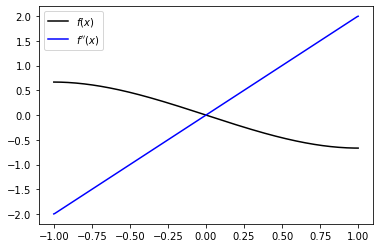

In [315]:
%matplotlib inline
_, ax = plt.subplots()

x = np.linspace(-1, 1, 300)
f = ((x ** 3) / 3) - x
d = second_derivative(f, x[1] - x[0])

ax.plot(x, f, color='k', label='$f(x)$')
ax.plot(x, d, color='b', label='$f\'\'(x)$')
ax.legend()

Note that this is a reasonable test function since we do indeed have $f'(x) = 0$ at the boundaries of the test domain $[-1, 1]$.

## Iterating Towards Equilibrium ##

Now we implement a loop to step the provided initial temperature towards equilibrium.

Converged after 9382 iterations.


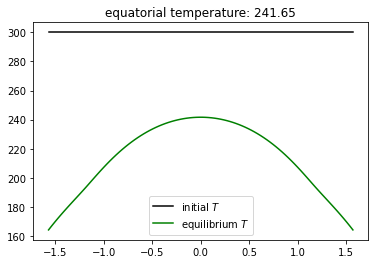

In [316]:
def equilibriate(T_0, max_iter=1e6, verbose=True):
    T = T_0
    dTdt = np.inf * np.ones(T.shape)
    
    n_iter = 0
    while abs(dTdt).max() > 1e-1 and n_iter < max_iter:
        dTdt = (
            S * (1 - albedo(T)) -
            (1 - 0.5 * eps) * sigma * (T ** 4) +
            D * second_derivative(T, dphi)
        )

        T = T + dTdt * dt
        n_iter = n_iter + 1
        
        if verbose and n_iter % int(max_iter / 10) == 0:
            print(f'Iteration {n_iter}: {abs(dTdt).max()}')
            
    if n_iter < max_iter:
        print(f'Converged after {n_iter} iterations.')
    else:
        print(f'Maximum iteration limit reached without convergence.')

    return T

T_0 = 300 * np.ones(phi.shape)
T = equilibriate(T_0)

%matplotlib inline
_, ax = plt.subplots()

ax.plot(phi, T_0, color='k', label='initial $T$')
ax.plot(phi, T, color='g', label=r'equilibrium $T$')

ax.set_title(f'equatorial temperature: {round(T[int(n_lats / 2)], 2)}')
ax.legend()

Now, let's investigate which equilibria we can reach. We'll start each simulation with an Earth at constant temperature across all latitudes, and see whether each starting temperature converges to the same temperature.

Converged after 8218 iterations.
Converged after 8778 iterations.
Converged after 9072 iterations.
Converged after 9253 iterations.
Converged after 9382 iterations.


Text(0, 0.5, 'final equatorial temperature')

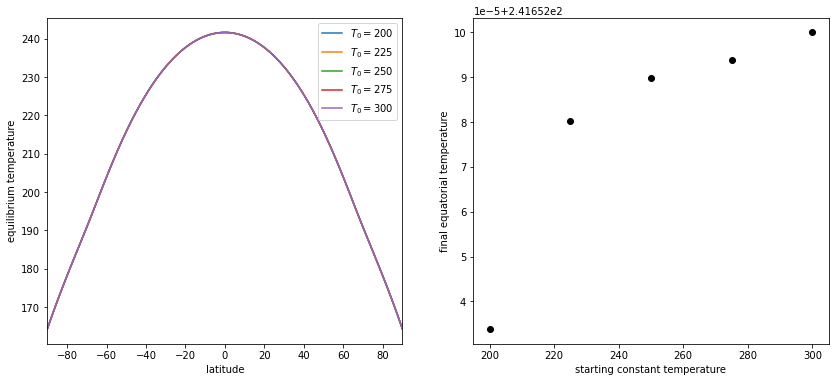

In [317]:
T_0s = 200 + 25 * np.arange(5)
eqs = np.zeros(T_0s.shape)

%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 6)

for i, T_0 in enumerate(T_0s):
    T = equilibriate(T_0 * np.ones(phi.shape), verbose=False)
    eqs[i] = T[int(n_lats / 2)]
    
    ax1.plot(lat, T, label=f'$T_0 = {T_0}$')
    
ax1.set_xlabel('latitude')
ax1.set_ylabel('equilibrium temperature')
ax1.set_xlim(-90, 90)
ax1.legend()

ax2.scatter(T_0s, eqs, color='k')
ax2.set_xlabel('starting constant temperature')
ax2.set_ylabel('final equatorial temperature')